# Actividad: Lasso vs. Ridge - Comparación de Modelos de Regularización

## 🎯 Objetivo de la Actividad
En esta actividad práctica, compararemos dos técnicas fundamentales de regularización en Machine Learning: **Ridge Regression** y **Lasso Regression**. 

### ¿Qué es la Regularización?
La regularización es una técnica que ayuda a prevenir el **overfitting** (sobreajuste) en nuestros modelos. Cuando un modelo se sobreajusta, memoriza los datos de entrenamiento pero no generaliza bien a nuevos datos.

### ¿Por qué comparar Ridge vs Lasso?
- **Ridge (L2)**: Reduce los coeficientes pero nunca los hace exactamente cero
- **Lasso (L1)**: Puede hacer que algunos coeficientes sean exactamente cero, eliminando variables

### 📋 Hipótesis que vamos a probar:
1. **Lasso** tendrá un error de predicción similar o mejor que Ridge
2. **Lasso** producirá un modelo más interpretable al reducir a cero los coeficientes de variables irrelevantes
3. **Ridge** mantendrá todos los coeficientes pero con valores pequeños

### 🧠 Conceptos Clave que Aprenderemos:
- **Penalización L1 vs L2**: Diferentes formas de regularizar
- **Selección de Variables**: Cómo Lasso puede eliminar automáticamente variables irrelevantes
- **Trade-off**: Interpretabilidad vs Rendimiento predictivo
- **Validación Cruzada**: Para encontrar el mejor parámetro de regularización

In [2]:
# 📚 Importar librerías necesarias
# NumPy: Para operaciones matemáticas y arrays
import numpy as np

# Pandas: Para manipulación y análisis de datos
import pandas as pd

# Matplotlib y Seaborn: Para visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: Librería principal de Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Configuración para evitar warnings innecesarios
import warnings
warnings.filterwarnings('ignore')

#  Configurar estilo de gráficos para que se vean más bonitos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Librerías importadas correctamente")
print("📊 Configuración de gráficos lista")
print("🚀 ¡Listos para comenzar la actividad!")

✅ Librerías importadas correctamente
📊 Configuración de gráficos lista
🚀 ¡Listos para comenzar la actividad!


## Paso 1: Generación de Datos Simulados

Para entender mejor cómo funcionan Ridge y Lasso, vamos a crear datos donde **sabemos exactamente** qué variables son importantes y cuáles no. Esto nos permitirá evaluar si nuestros modelos pueden identificar correctamente las variables relevantes.

### 🎯 Estructura de nuestros datos:
- **10 variables relevantes**: Que realmente afectan el ingreso anual
- **20 variables irrelevantes**: Que no tienen relación con el ingreso
- **1000 observaciones**: Para tener suficientes datos
- **Ruido**: Para simular condiciones reales (nada es perfecto en la vida real)

### 🧠 Concepto importante: Coeficientes Verdaderos
En la vida real, nunca sabemos los "coeficientes verdaderos", pero aquí los definimos para poder evaluar qué tan bien funcionan nuestros modelos.

### 📈 Variables que simularemos:
1. **Educación** (coef = 5000): Años de estudio
2. **Experiencia laboral** (coef = 3000): Años trabajando
3. **Edad** (coef = 2000): Edad del trabajador
4. **Horas trabajadas** (coef = 1500): Horas semanales
5. **Sector económico** (coef = 1000): Tipo de industria
6. **Tamaño de empresa** (coef = 800): Número de empleados
7. **Nivel de responsabilidad** (coef = 600): Cargo en la empresa
8. **Ubicación geográfica** (coef = 400): Ciudad/región
9. **Certificaciones** (coef = 300): Certificaciones profesionales
10. **Idiomas** (coef = 200): Número de idiomas hablados

In [32]:
# 🔧 Configurar semilla para reproducibilidad
# Esto asegura que obtengamos los mismos resultados cada vez que ejecutemos el código
np.random.seed(42)

# 📊 Parámetros de la simulación
n_samples = 3000                    # Número de personas en nuestro dataset
n_relevant_features = 10            # Variables que realmente afectan el ingreso
n_irrelevant_features = 20          # Variables que NO afectan el ingreso
n_total_features = n_relevant_features + n_irrelevant_features

print(f"🎯 Creando dataset con {n_samples} personas y {n_total_features} variables")
print(f"📈 Variables relevantes: {n_relevant_features}")
print(f"❌ Variables irrelevantes: {n_irrelevant_features}")

# 🎲 Generar variables explicativas (características de cada persona)
# randn genera números aleatorios con distribución normal
X = np.random.randn(n_samples, n_total_features)

# 🎯 Definir coeficientes reales (solo las primeras 10 variables son relevantes)
true_coefficients = np.zeros(n_total_features)  # Inicializar todos en cero
true_coefficients[:n_relevant_features] = np.array([
    5000,  # Educación: Cada año adicional suma $5000 al ingreso
    3000,  # Experiencia laboral: Cada año de experiencia suma $3000
    2000,  # Edad: La edad tiene un efecto moderado
    1500,  # Horas trabajadas: Más horas = más ingreso
    1000,  # Sector económico: Algunos sectores pagan mejor
    800,   # Tamaño de empresa: Empresas grandes suelen pagar más
    600,   # Nivel de responsabilidad: Más responsabilidad = más pago
    400,   # Ubicación geográfica: Algunas ciudades pagan mejor
    300,   # Certificaciones: Certificaciones profesionales aumentan el ingreso
    200    # Idiomas: Cada idioma adicional suma un poco
])

print("\n💰 Coeficientes verdaderos (solo las primeras 10 variables son relevantes):")
for i, coef in enumerate(true_coefficients[:n_relevant_features]):
    print(f"   Variable {i+1}: ${coef:.0f}")

# 🎯 Generar variable objetivo (ingreso anual) con ruido
# La fórmula es: ingreso = X1*coef1 + X2*coef2 + ... + ruido
y = X @ true_coefficients + np.random.normal(0, 1000, n_samples)

# 📝 Crear nombres de variables para mejor interpretación
feature_names = []
for i in range(n_relevant_features):
    feature_names.append(f'Variable_Relevante_{i+1}')
for i in range(n_irrelevant_features):
    feature_names.append(f'Variable_Irrelevante_{i+1}')

# 📊 Crear DataFrame con pandas
df = pd.DataFrame(X, columns=feature_names)
df['ingreso_anual'] = y

# 📈 Mostrar resumen del dataset
print(f"\n✅ Dataset creado exitosamente!")
print(f"📊 Observaciones: {n_samples}")
print(f"📈 Variables totales: {n_total_features}")
print(f"💰 Rango de ingresos: ${y.min():.0f} - ${y.max():.0f}")
print(f"💰 Ingreso promedio: ${y.mean():.0f}")
print(f"💰 Desviación estándar: ${y.std():.0f}")

print("\n📋 Primeras 5 filas del dataset:")
print(df.head())

print("\n🔍 Información del dataset:")
print(df.info())

🎯 Creando dataset con 3000 personas y 30 variables
📈 Variables relevantes: 10
❌ Variables irrelevantes: 20

💰 Coeficientes verdaderos (solo las primeras 10 variables son relevantes):
   Variable 1: $5000
   Variable 2: $3000
   Variable 3: $2000
   Variable 4: $1500
   Variable 5: $1000
   Variable 6: $800
   Variable 7: $600
   Variable 8: $400
   Variable 9: $300
   Variable 10: $200

✅ Dataset creado exitosamente!
📊 Observaciones: 3000
📈 Variables totales: 30
💰 Rango de ingresos: $-25990 - $27687
💰 Ingreso promedio: $60
💰 Desviación estándar: $6639

📋 Primeras 5 filas del dataset:
   Variable_Relevante_1  Variable_Relevante_2  Variable_Relevante_3  \
0              0.496714             -0.138264              0.647689   
1             -0.601707              1.852278             -0.013497   
2             -0.479174             -0.185659             -1.106335   
3              0.097078              0.968645             -0.702053   
4              0.791032             -0.909387         

## Paso 2: Preparación de los Datos

### ¿Por qué necesitamos preparar los datos?

Antes de entrenar nuestros modelos, necesitamos hacer algunos ajustes importantes:

1. **Separar variables explicativas y objetivo**: Distinguir entre lo que queremos predecir y lo que usamos para predecir
2. **Dividir en entrenamiento y prueba**: Para evaluar qué tan bien generaliza nuestro modelo
3. **Estandarizar las variables**: Para que todas las variables tengan la misma escala

### 🧠 Conceptos importantes:

**Train-Test Split**: Dividimos nuestros datos en dos partes:
- **Datos de entrenamiento** (70%): Para enseñar al modelo
- **Datos de prueba** (30%): Para evaluar qué tan bien funciona

**Estandarización**: Convertimos todas las variables a la misma escala (media=0, desviación=1). Esto es importante porque:
- Ridge y Lasso son sensibles a la escala de las variables
- Variables con valores grandes pueden dominar el modelo
- La estandarización hace que todas las variables tengan igual importancia inicial

In [33]:
# 📊 Separar variables explicativas (X) y variable objetivo (y)
print("🔍 Separando variables explicativas y objetivo...")
X = df.drop('ingreso_anual', axis=1)  # Todas las variables excepto el ingreso
y = df['ingreso_anual']               # Solo el ingreso (lo que queremos predecir)

print(f"📈 Variables explicativas (X): {X.shape[1]} variables")
print(f"🎯 Variable objetivo (y): 1 variable (ingreso anual)")
print(f"📊 Total de observaciones: {X.shape[0]}")

# 🔄 Dividir en conjuntos de entrenamiento y prueba
print("\n🔄 Dividiendo datos en entrenamiento (70%) y prueba (30%)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42  # 30% para prueba, semilla para reproducibilidad
)

print(f"📚 Datos de entrenamiento: {X_train.shape[0]} observaciones")
print(f"🧪 Datos de prueba: {X_test.shape[0]} observaciones")
print(f"📈 Variables en cada conjunto: {X_train.shape[1]}")

# ⚖️ Estandarizar las variables (muy importante para Ridge y Lasso)
print("\n⚖️ Estandarizando variables...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Ajustar y transformar datos de entrenamiento
X_test_scaled = scaler.transform(X_test)        # Solo transformar datos de prueba

print("✅ Estandarización completada!")
print("📊 Ahora todas las variables tienen media=0 y desviación=1")

# 🔍 Verificar la estandarización
print("\n🔍 Verificando la estandarización:")
print(f"Media de variables estandarizadas: {X_train_scaled.mean():.6f} (debería ser ~0)")
print(f"Desviación de variables estandarizadas: {X_train_scaled.std():.6f} (debería ser ~1)")

print("\n✅ ¡Datos preparados y listos para entrenar modelos!")

🔍 Separando variables explicativas y objetivo...
📈 Variables explicativas (X): 30 variables
🎯 Variable objetivo (y): 1 variable (ingreso anual)
📊 Total de observaciones: 3000

🔄 Dividiendo datos en entrenamiento (70%) y prueba (30%)...
📚 Datos de entrenamiento: 2100 observaciones
🧪 Datos de prueba: 900 observaciones
📈 Variables en cada conjunto: 30

⚖️ Estandarizando variables...
✅ Estandarización completada!
📊 Ahora todas las variables tienen media=0 y desviación=1

🔍 Verificando la estandarización:
Media de variables estandarizadas: 0.000000 (debería ser ~0)
Desviación de variables estandarizadas: 1.000000 (debería ser ~1)

✅ ¡Datos preparados y listos para entrenar modelos!


## Paso 3: Entrenamiento del Modelo Ridge

### ¿Qué es Ridge Regression?

**Ridge Regression** es una técnica de regularización que usa **penalización L2**. Su objetivo es reducir el overfitting agregando una penalización a los coeficientes grandes.

### 🧠 Concepto clave: Penalización L2

La función objetivo de Ridge es:
```
Error = Error de predicción + α × (β₁² + β₂² + ... + βₚ²)
```

Donde:
- **α (alpha)**: Parámetro de regularización (controla la fuerza de la penalización)
- **βᵢ²**: Cuadrado de cada coeficiente

### 🔍 ¿Cómo funciona Ridge?

1. **Reduce coeficientes**: Hace que los coeficientes sean más pequeños
2. **Nunca los hace cero**: Los coeficientes se acercan a cero pero nunca llegan exactamente a cero
3. **Mantiene todas las variables**: Todas las variables siguen en el modelo

### 🎯 ¿Cuándo usar Ridge?

- Cuando todas las variables podrían ser relevantes
- Cuando quieres evitar eliminar variables potencialmente útiles
- Cuando el rendimiento predictivo es la prioridad

### 📊 Proceso que vamos a seguir:

1. **Probar diferentes valores de alpha**: Para encontrar el mejor parámetro
2. **Usar validación cruzada**: Para evaluar cada valor de alpha
3. **Entrenar el modelo final**: Con el mejor alpha encontrado
4. **Evaluar el rendimiento**: En datos de prueba

In [34]:
# 🎯 Definir valores de alpha para Ridge
print("🔍 Buscando el mejor parámetro alpha para Ridge...")
print("📊 Probando valores desde 0.001 hasta 1000...")

# Usar logspace para probar valores en escala logarítmica
alpha_values = np.logspace(-3, 3, 50)  # 50 valores entre 10^-3 y 10^3
print(f"🎯 Probando {len(alpha_values)} valores diferentes de alpha")





🔍 Buscando el mejor parámetro alpha para Ridge...
📊 Probando valores desde 0.001 hasta 1000...
🎯 Probando 50 valores diferentes de alpha


In [35]:
# 🔄 Entrenar Ridge con validación cruzada para cada alpha
print("\n🔄 Entrenando modelos Ridge con validación cruzada...")
ridge_scores = []

for i, alpha in enumerate(alpha_values):
    ridge = Ridge(alpha=alpha)
    # Usar validación cruzada con 5 folds
    scores = cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    ridge_scores.append(-np.mean(scores))  # Convertir a error positivo
    
    # Mostrar progreso cada 10 iteraciones
    if (i + 1) % 10 == 0:
        print(f"   Progreso: {i+1}/{len(alpha_values)} alphas probados")

# 🏆 Encontrar el mejor alpha
best_alpha_ridge = alpha_values[np.argmin(ridge_scores)]
best_score_ridge = min(ridge_scores)

print(f"\n🏆 Mejor alpha encontrado: {best_alpha_ridge:.4f}")
print(f"📊 Mejor error MSE: {best_score_ridge:.2f}")


🔄 Entrenando modelos Ridge con validación cruzada...
   Progreso: 10/50 alphas probados
   Progreso: 20/50 alphas probados
   Progreso: 30/50 alphas probados
   Progreso: 40/50 alphas probados
   Progreso: 50/50 alphas probados

🏆 Mejor alpha encontrado: 0.8685
📊 Mejor error MSE: 985625.87


In [36]:
# 🚀 Entrenar modelo Ridge final con el mejor alpha
print("\n🚀 Entrenando modelo Ridge final con el mejor alpha...")
ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_train_scaled, y_train)

# 📈 Hacer predicciones en datos de prueba
y_pred_ridge = ridge_model.predict(X_test_scaled)

# 📊 Calcular métricas de rendimiento
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print("\n📊 RESULTADOS DEL MODELO RIDGE:")
print(f"🎯 Mejor alpha: {best_alpha_ridge:.4f}")
print(f"💰 RMSE (Error de predicción): ${rmse_ridge:.2f}")
print(f"📈 R² (Coeficiente de determinación): {r2_ridge:.4f}")

# 🔍 Analizar coeficientes
ridge_non_zero = np.sum(ridge_model.coef_ != 0)
print(f"📊 Coeficientes no cero: {ridge_non_zero}/{len(ridge_model.coef_)}")
print(f"📊 Porcentaje de variables usadas: {ridge_non_zero/len(ridge_model.coef_)*100:.1f}%")

# 📊 Mostrar algunos coeficientes como ejemplo
print("\n🔍 Ejemplos de coeficientes Ridge:")
coef_ridge_df = pd.DataFrame({
    'Variable': feature_names,
    'Coeficiente': ridge_model.coef_
})
print(coef_ridge_df.head(10))


🚀 Entrenando modelo Ridge final con el mejor alpha...

📊 RESULTADOS DEL MODELO RIDGE:
🎯 Mejor alpha: 0.8685
💰 RMSE (Error de predicción): $1019.01
📈 R² (Coeficiente de determinación): 0.9760
📊 Coeficientes no cero: 30/30
📊 Porcentaje de variables usadas: 100.0%

🔍 Ejemplos de coeficientes Ridge:
                Variable  Coeficiente
0   Variable_Relevante_1  5073.756823
1   Variable_Relevante_2  2973.242039
2   Variable_Relevante_3  1992.872119
3   Variable_Relevante_4  1502.718135
4   Variable_Relevante_5   995.215821
5   Variable_Relevante_6   787.021323
6   Variable_Relevante_7   603.368329
7   Variable_Relevante_8   358.664601
8   Variable_Relevante_9   294.633918
9  Variable_Relevante_10   202.632471


## Paso 4: Entrenamiento del Modelo Lasso

### ¿Qué es Lasso Regression?

**Lasso Regression** es una técnica de regularización que usa **penalización L1**. Su objetivo es reducir el overfitting y realizar **selección automática de variables**.

### 🧠 Concepto clave: Penalización L1

La función objetivo de Lasso es:
```
Error = Error de predicción + α × (|β₁| + |β₂| + ... + |βₚ|)
```

Donde:
- **α (alpha)**: Parámetro de regularización (controla la fuerza de la penalización)
- **|βᵢ|**: Valor absoluto de cada coeficiente

### 🔍 ¿Cómo funciona Lasso?

1. **Reduce coeficientes**: Hace que los coeficientes sean más pequeños
2. **Puede hacerlos cero**: Los coeficientes pueden llegar exactamente a cero
3. **Selección de variables**: Elimina automáticamente variables irrelevantes

### 🎯 ¿Cuándo usar Lasso?

- Cuando tienes muchas variables y quieres identificar las más importantes
- Cuando la interpretabilidad es crucial
- Cuando quieres un modelo más simple y fácil de explicar
- Cuando sospechas que muchas variables son irrelevantes

### 🆚 Diferencias clave con Ridge:

| Aspecto | Ridge (L2) | Lasso (L1) |
|---------|------------|------------|
| Penalización | βᵢ² (cuadrado) | \|βᵢ\| (valor absoluto) |
| Coeficientes cero | Nunca | Pueden ser cero |
| Selección de variables | No | Sí |
| Interpretabilidad | Baja | Alta |

### 📊 Proceso que vamos a seguir:

1. **Probar diferentes valores de alpha**: Para encontrar el mejor parámetro
2. **Usar validación cruzada**: Para evaluar cada valor de alpha
3. **Entrenar el modelo final**: Con el mejor alpha encontrado
4. **Evaluar el rendimiento**: En datos de prueba
5. **Analizar selección de variables**: Ver qué variables fueron eliminadas

In [37]:
# 🎯 Definir valores de alpha para Lasso
print("🔍 Buscando el mejor parámetro alpha para Lasso...")
print("📊 Probando valores desde 0.001 hasta 10...")

# Usar logspace para probar valores en escala logarítmica
alpha_values_lasso = np.logspace(-3, 1, 50)  # 50 valores entre 10^-3 y 10^1
print(f"🎯 Probando {len(alpha_values_lasso)} valores diferentes de alpha")

# 🔄 Entrenar Lasso con validación cruzada para cada alpha
print("\n🔄 Entrenando modelos Lasso con validación cruzada...")
lasso_scores = []

for i, alpha in enumerate(alpha_values_lasso):
    lasso = Lasso(alpha=alpha, max_iter=2000)  # Más iteraciones para convergencia
    # Usar validación cruzada con 5 folds
    scores = cross_val_score(lasso, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    lasso_scores.append(-np.mean(scores))  # Convertir a error positivo
    
    # Mostrar progreso cada 10 iteraciones
    if (i + 1) % 10 == 0:
        print(f"   Progreso: {i+1}/{len(alpha_values_lasso)} alphas probados")

# 🏆 Encontrar el mejor alpha
best_alpha_lasso = alpha_values_lasso[np.argmin(lasso_scores)]
best_score_lasso = min(lasso_scores)

print(f"\n🏆 Mejor alpha encontrado: {best_alpha_lasso:.4f}")
print(f"📊 Mejor error MSE: {best_score_lasso:.2f}")






🔍 Buscando el mejor parámetro alpha para Lasso...
📊 Probando valores desde 0.001 hasta 10...
🎯 Probando 50 valores diferentes de alpha

🔄 Entrenando modelos Lasso con validación cruzada...
   Progreso: 10/50 alphas probados
   Progreso: 20/50 alphas probados
   Progreso: 30/50 alphas probados
   Progreso: 40/50 alphas probados
   Progreso: 50/50 alphas probados

🏆 Mejor alpha encontrado: 10.0000
📊 Mejor error MSE: 979564.43


In [38]:
# 🚀 Entrenar modelo Lasso final con el mejor alpha
print("\n🚀 Entrenando modelo Lasso final con el mejor alpha...")
lasso_model = Lasso(alpha=best_alpha_lasso, max_iter=2000)
lasso_model.fit(X_train_scaled, y_train)

# 📈 Hacer predicciones en datos de prueba
y_pred_lasso = lasso_model.predict(X_test_scaled)

# 📊 Calcular métricas de rendimiento
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)



🚀 Entrenando modelo Lasso final con el mejor alpha...


In [39]:
print("\n📊 RESULTADOS DEL MODELO LASSO:")
print(f"🎯 Mejor alpha: {best_alpha_lasso:.4f}")
print(f"💰 RMSE (Error de predicción): ${rmse_lasso:.2f}")
print(f"📈 R² (Coeficiente de determinación): {r2_lasso:.4f}")

# 🔍 Analizar coeficientes y selección de variables
lasso_non_zero = np.sum(lasso_model.coef_ != 0)
lasso_zero = np.sum(lasso_model.coef_ == 0)

print(f"📊 Coeficientes no cero: {lasso_non_zero}/{len(lasso_model.coef_)}")
print(f"📊 Coeficientes cero (variables eliminadas): {lasso_zero}/{len(lasso_model.coef_)}")
print(f"📊 Porcentaje de variables usadas: {lasso_non_zero/len(lasso_model.coef_)*100:.1f}%")
print(f"📊 Porcentaje de variables eliminadas: {lasso_zero/len(lasso_model.coef_)*100:.1f}%")


📊 RESULTADOS DEL MODELO LASSO:
🎯 Mejor alpha: 10.0000
💰 RMSE (Error de predicción): $1017.98
📈 R² (Coeficiente de determinación): 0.9760
📊 Coeficientes no cero: 22/30
📊 Coeficientes cero (variables eliminadas): 8/30
📊 Porcentaje de variables usadas: 73.3%
📊 Porcentaje de variables eliminadas: 26.7%


In [40]:
# 📊 Mostrar variables seleccionadas y eliminadas
print("\n🔍 Variables seleccionadas por Lasso (coeficiente ≠ 0):")
lasso_selected_vars = []
lasso_eliminated_vars = []

for i, (var, coef) in enumerate(zip(feature_names, lasso_model.coef_)):
    if coef != 0:
        lasso_selected_vars.append((var, coef))
    else:
        lasso_eliminated_vars.append(var)

print(f"✅ Variables seleccionadas ({len(lasso_selected_vars)}):")
for var, coef in lasso_selected_vars[:10]:  # Mostrar solo las primeras 10
    print(f"   {var}: {coef:.4f}")

if len(lasso_eliminated_vars) > 0:
    print(f"\n❌ Variables eliminadas ({len(lasso_eliminated_vars)}):")
    for var in lasso_eliminated_vars[:10]:  # Mostrar solo las primeras 10
        print(f"   {var}")

print(f"\n🎯 ¡Lasso eliminó {len(lasso_eliminated_vars)} variables irrelevantes!")


🔍 Variables seleccionadas por Lasso (coeficiente ≠ 0):
✅ Variables seleccionadas (22):
   Variable_Relevante_1: 5065.2554
   Variable_Relevante_2: 2964.6932
   Variable_Relevante_3: 1984.1805
   Variable_Relevante_4: 1494.0219
   Variable_Relevante_5: 986.1430
   Variable_Relevante_6: 775.3523
   Variable_Relevante_7: 591.5508
   Variable_Relevante_8: 349.0390
   Variable_Relevante_9: 284.1215
   Variable_Relevante_10: 192.5615

❌ Variables eliminadas (8):
   Variable_Irrelevante_1
   Variable_Irrelevante_2
   Variable_Irrelevante_7
   Variable_Irrelevante_13
   Variable_Irrelevante_14
   Variable_Irrelevante_16
   Variable_Irrelevante_17
   Variable_Irrelevante_20

🎯 ¡Lasso eliminó 8 variables irrelevantes!


## Paso 5: Comparación Visual de Coeficientes


La visualización nos ayuda a entender mejor cómo funcionan Ridge y Lasso:

1. **Ridge**: Todos los coeficientes son pequeños pero no cero
2. **Lasso**: Algunos coeficientes son exactamente cero (variables eliminadas)

### 🧠 Conceptos clave de la visualización:

- **Altura de las barras**: Magnitud del coeficiente
- **Barras en cero**: Variables eliminadas por Lasso
- **Patrón de distribución**: Cómo se distribuyen los coeficientes

### 📈 Lo que vamos a observar:

1. **Diferencias en magnitud**: Ridge vs Lasso
2. **Selección de variables**: Variables eliminadas por Lasso
3. **Interpretabilidad**: Cuál modelo es más fácil de interpretar

### 🎯 Preguntas que responderemos:

- ¿Cuántas variables eliminó Lasso?
- ¿Qué variables considera más importantes cada modelo?
- ¿Cuál modelo es más interpretable?

🎨 Creando visualización comparativa de coeficientes...
📈 Preparando gráfico de coeficientes Ridge...
📈 Preparando gráfico de coeficientes Lasso...


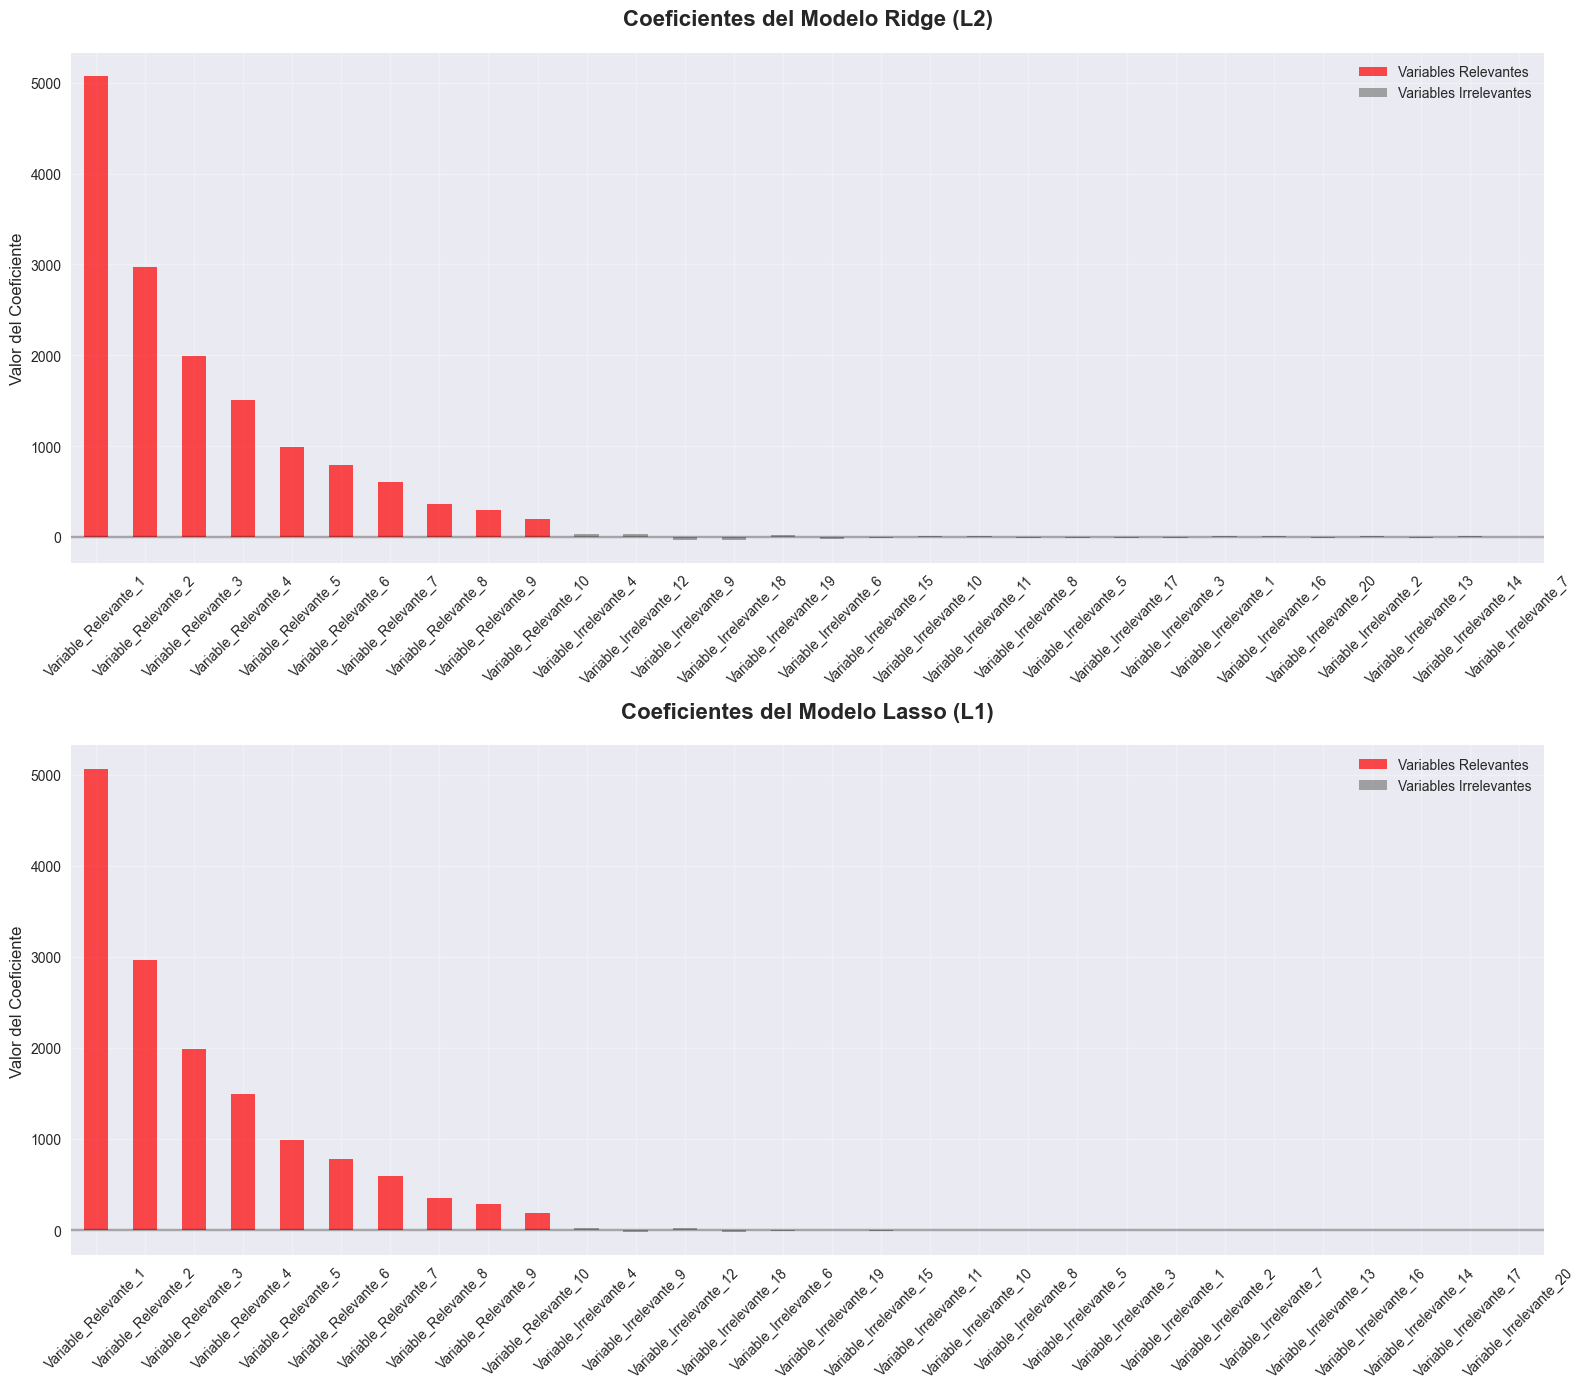


📊 ANÁLISIS COMPARATIVO DE COEFICIENTES

🏔️ ANÁLISIS RIDGE:
📊 Total de variables: 30
📊 Variables con coeficiente > 0.1: 30
📊 Variables con coeficiente > 1.0: 30
📊 Rango de coeficientes: -30.2948 a 5073.7568

🎯 ANÁLISIS LASSO:
📊 Total de variables: 30
📊 Variables seleccionadas (≠ 0): 22
📊 Variables eliminadas (= 0): 8
📊 Rango de coeficientes: -23.8760 a 5065.2554

🏆 COMPARACIÓN:
📊 Variables usadas por Ridge: 30 (100%)
📊 Variables usadas por Lasso: 22 (73.3%)
📊 Reducción de variables por Lasso: 8 variables


In [41]:
# 📊 Crear figura con subplots para comparar Ridge vs Lasso
print("🎨 Creando visualización comparativa de coeficientes...")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 14))

# 🏔️ Gráfico de coeficientes Ridge
print("📈 Preparando gráfico de coeficientes Ridge...")
coef_ridge = pd.Series(ridge_model.coef_, index=feature_names)
coef_ridge_sorted = coef_ridge.sort_values(key=abs, ascending=False)

# Crear barras con colores diferentes para variables relevantes vs irrelevantes
colors_ridge = ['red' if i < n_relevant_features else 'gray' for i in range(len(coef_ridge_sorted))]
coef_ridge_sorted.plot(kind='bar', ax=ax1, color=colors_ridge, alpha=0.7)

ax1.set_title('Coeficientes del Modelo Ridge (L2)', fontsize=16, fontweight='bold', pad=20)
ax1.set_ylabel('Valor del Coeficiente', fontsize=12)
ax1.tick_params(axis='x', rotation=45, labelsize=10)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Agregar leyenda
from matplotlib.patches import Patch
legend_elements_ridge = [
    Patch(facecolor='red', alpha=0.7, label='Variables Relevantes'),
    Patch(facecolor='gray', alpha=0.7, label='Variables Irrelevantes')
]
ax1.legend(handles=legend_elements_ridge, loc='upper right')

# 🎯 Gráfico de coeficientes Lasso
print("📈 Preparando gráfico de coeficientes Lasso...")
coef_lasso = pd.Series(lasso_model.coef_, index=feature_names)
coef_lasso_sorted = coef_lasso.sort_values(key=abs, ascending=False)

# Crear barras con colores diferentes
colors_lasso = ['red' if i < n_relevant_features else 'gray' for i in range(len(coef_lasso_sorted))]
coef_lasso_sorted.plot(kind='bar', ax=ax2, color=colors_lasso, alpha=0.7)

ax2.set_title('Coeficientes del Modelo Lasso (L1)', fontsize=16, fontweight='bold', pad=20)
ax2.set_ylabel('Valor del Coeficiente', fontsize=12)
ax2.tick_params(axis='x', rotation=45, labelsize=10)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Agregar leyenda
legend_elements_lasso = [
    Patch(facecolor='red', alpha=0.7, label='Variables Relevantes'),
    Patch(facecolor='gray', alpha=0.7, label='Variables Irrelevantes')
]
ax2.legend(handles=legend_elements_lasso, loc='upper right')

plt.tight_layout()
plt.show()

# 📊 Análisis detallado de los resultados
print("\n" + "="*80)
print("📊 ANÁLISIS COMPARATIVO DE COEFICIENTES")
print("="*80)

# 🏔️ Análisis Ridge
print("\n🏔️ ANÁLISIS RIDGE:")
print(f"📊 Total de variables: {len(coef_ridge)}")
print(f"📊 Variables con coeficiente > 0.1: {np.sum(np.abs(coef_ridge) > 0.1)}")
print(f"📊 Variables con coeficiente > 1.0: {np.sum(np.abs(coef_ridge) > 1.0)}")
print(f"📊 Rango de coeficientes: {coef_ridge.min():.4f} a {coef_ridge.max():.4f}")

# 🎯 Análisis Lasso
print("\n🎯 ANÁLISIS LASSO:")
print(f"📊 Total de variables: {len(coef_lasso)}")
print(f"📊 Variables seleccionadas (≠ 0): {np.sum(coef_lasso != 0)}")
print(f"📊 Variables eliminadas (= 0): {np.sum(coef_lasso == 0)}")
print(f"📊 Rango de coeficientes: {coef_lasso.min():.4f} a {coef_lasso.max():.4f}")

# 🏆 Comparación
print("\n🏆 COMPARACIÓN:")
print(f"📊 Variables usadas por Ridge: {len(coef_ridge)} (100%)")
print(f"📊 Variables usadas por Lasso: {np.sum(coef_lasso != 0)} ({np.sum(coef_lasso != 0)/len(coef_lasso)*100:.1f}%)")
print(f"📊 Reducción de variables por Lasso: {len(coef_lasso) - np.sum(coef_lasso != 0)} variables")



In [42]:
# 📋 Mostrar las variables más importantes según cada modelo
print("\n" + "="*80)
print("📋 TOP 10 VARIABLES MÁS IMPORTANTES")
print("="*80)

print("\n🏔️ Ridge (por valor absoluto):")
for i, (var, coef) in enumerate(coef_ridge_sorted.head(10).items()):
    relevante = "✅" if i < n_relevant_features else "❌"
    print(f"{i+1:2d}. {var}: {coef:.4f} {relevante}")

print("\n🎯 Lasso (variables seleccionadas):")
lasso_selected = coef_lasso[coef_lasso != 0].sort_values(key=abs, ascending=False)
for i, (var, coef) in enumerate(lasso_selected.items()):
    relevante = "✅" if var in feature_names[:n_relevant_features] else "❌"
    print(f"{i+1:2d}. {var}: {coef:.4f} {relevante}")

print("\n📊 Resumen:")
print(f"✅ Ridge identificó {np.sum(coef_ridge_sorted.head(10).index.isin(feature_names[:n_relevant_features]))} variables relevantes en su top 10")
print(f"✅ Lasso identificó {np.sum(lasso_selected.head(10).index.isin(feature_names[:n_relevant_features]))} variables relevantes en su top 10")


📋 TOP 10 VARIABLES MÁS IMPORTANTES

🏔️ Ridge (por valor absoluto):
 1. Variable_Relevante_1: 5073.7568 ✅
 2. Variable_Relevante_2: 2973.2420 ✅
 3. Variable_Relevante_3: 1992.8721 ✅
 4. Variable_Relevante_4: 1502.7181 ✅
 5. Variable_Relevante_5: 995.2158 ✅
 6. Variable_Relevante_6: 787.0213 ✅
 7. Variable_Relevante_7: 603.3683 ✅
 8. Variable_Relevante_8: 358.6646 ✅
 9. Variable_Relevante_9: 294.6339 ✅
10. Variable_Relevante_10: 202.6325 ✅

🎯 Lasso (variables seleccionadas):
 1. Variable_Relevante_1: 5065.2554 ✅
 2. Variable_Relevante_2: 2964.6932 ✅
 3. Variable_Relevante_3: 1984.1805 ✅
 4. Variable_Relevante_4: 1494.0219 ✅
 5. Variable_Relevante_5: 986.1430 ✅
 6. Variable_Relevante_6: 775.3523 ✅
 7. Variable_Relevante_7: 591.5508 ✅
 8. Variable_Relevante_8: 349.0390 ✅
 9. Variable_Relevante_9: 284.1215 ✅
10. Variable_Relevante_10: 192.5615 ✅
11. Variable_Irrelevante_4: 24.8080 ❌
12. Variable_Irrelevante_9: -23.8760 ❌
13. Variable_Irrelevante_12: 19.4462 ❌
14. Variable_Irrelevante_18: -

## 📊 Paso 6: Tabla de Resultados Comparativos


Una tabla nos permite ver de manera clara y organizada las diferencias entre Ridge y Lasso en términos de:

1. **Rendimiento predictivo**: ¿Cuál modelo predice mejor?
2. **Interpretabilidad**: ¿Cuál modelo es más fácil de entender?
3. **Selección de variables**: ¿Cuál modelo identifica mejor las variables importantes?

### 🧠 Métricas que vamos a comparar:

- **RMSE**: Error de predicción (menor es mejor)
- **R²**: Coeficiente de determinación (más cercano a 1 es mejor)
- **Número de variables**: Cuántas variables usa cada modelo
- **Capacidad de selección**: Qué tan bien identifica variables relevantes



In [48]:
# 📊 Crear tabla de resultados comparativos
print("📋 Creando tabla comparativa de resultados...")

# Calcular métricas adicionales para el análisis
ridge_relevant_identified = np.sum(ridge_model.coef_[:n_relevant_features] != 0)
ridge_irrelevant_eliminated = np.sum(ridge_model.coef_[n_relevant_features:] == 0)
lasso_relevant_identified = np.sum(lasso_model.coef_[:n_relevant_features] != 0)
lasso_irrelevant_eliminated = np.sum(lasso_model.coef_[n_relevant_features:] == 0)

# Calcular porcentajes
ridge_relevant_pct = ridge_relevant_identified / n_relevant_features * 100
ridge_irrelevant_pct = ridge_irrelevant_eliminated / n_irrelevant_features * 100
lasso_relevant_pct = lasso_relevant_identified / n_relevant_features * 100
lasso_irrelevant_pct = lasso_irrelevant_eliminated / n_irrelevant_features * 100

# Crear tabla de resultados
resultados = pd.DataFrame({
    'Métrica': [
        '💰 RMSE (Error de Predicción)', 
        '📈 R² (Coeficiente de Determinación)',
        '📊 Número de Variables Usadas',
        '✅ Variables Relevantes Identificadas',
        '❌ Variables Irrelevantes Eliminadas',
        '🎯 Precisión en Selección (%)',
        '🎯 Especificidad (%)'
    ],
    'Ridge': [
        f"${rmse_ridge:.2f}", 
        f"{r2_ridge:.4f}",
        f"{ridge_non_zero}/{len(ridge_model.coef_)} (100%)",
        f"{ridge_relevant_identified}/{n_relevant_features} ({ridge_relevant_pct:.1f}%)",
        f"{ridge_irrelevant_eliminated}/{n_irrelevant_features} ({ridge_irrelevant_pct:.1f}%)",
        f"{ridge_relevant_pct:.1f}%",
        f"{ridge_irrelevant_pct:.1f}%"
    ],
    'Lasso': [
        f"${rmse_lasso:.2f}", 
        f"{r2_lasso:.4f}",
        f"{lasso_non_zero}/{len(lasso_model.coef_)} ({lasso_non_zero/len(lasso_model.coef_)*100:.1f}%)",
        f"{lasso_relevant_identified}/{n_relevant_features} ({lasso_relevant_pct:.1f}%)",
        f"{lasso_irrelevant_eliminated}/{n_irrelevant_features} ({lasso_irrelevant_pct:.1f}%)",
        f"{lasso_relevant_pct:.1f}%",
        f"{lasso_irrelevant_pct:.1f}%"
    ]
})

# Mostrar tabla con formato mejorado
print("\n" + "="*100)
print("📊 TABLA DE RESULTADOS: RIDGE vs LASSO")
print("="*100)
print(resultados.to_string(index=False))
print("="*100)



📋 Creando tabla comparativa de resultados...

📊 TABLA DE RESULTADOS: RIDGE vs LASSO
                             Métrica          Ridge          Lasso
        💰 RMSE (Error de Predicción)       $1019.01       $1017.98
 📈 R² (Coeficiente de Determinación)         0.9760         0.9760
        📊 Número de Variables Usadas   30/30 (100%)  22/30 (73.3%)
✅ Variables Relevantes Identificadas 10/10 (100.0%) 10/10 (100.0%)
 ❌ Variables Irrelevantes Eliminadas    0/20 (0.0%)   8/20 (40.0%)
        🎯 Precisión en Selección (%)         100.0%         100.0%
                 🎯 Especificidad (%)           0.0%          40.0%


In [49]:
# 📊 Análisis de la tabla
print("\n📊 ANÁLISIS DE RESULTADOS:")

# Comparar rendimiento predictivo
if rmse_lasso < rmse_ridge:
    print(f"🏆 RENDIMIENTO PREDICTIVO: Lasso es mejor por ${rmse_ridge - rmse_lasso:.2f}")
elif rmse_ridge < rmse_lasso:
    print(f"🏆 RENDIMIENTO PREDICTIVO: Ridge es mejor por ${rmse_lasso - rmse_ridge:.2f}")
else:
    print("🏆 RENDIMIENTO PREDICTIVO: Ambos modelos tienen rendimiento similar")

# Comparar interpretabilidad
reduccion_variables = len(ridge_model.coef_) - lasso_non_zero
print(f"\n📊 INTERPRETABILIDAD:")
print(f"   • Ridge usa todas las {len(ridge_model.coef_)} variables")
print(f"   • Lasso usa solo {lasso_non_zero} variables ({reduccion_variables} menos)")
print(f"   • Lasso eliminó {reduccion_variables/len(ridge_model.coef_)*100:.1f}% de las variables")

# Comparar capacidad de selección
print(f"\n🎯 CAPACIDAD DE SELECCIÓN:")
print(f"   • Ridge identificó {ridge_relevant_pct:.1f}% de variables relevantes")
print(f"   • Lasso identificó {lasso_relevant_pct:.1f}% de variables relevantes")
print(f"   • Ridge eliminó {ridge_irrelevant_pct:.1f}% de variables irrelevantes")
print(f"   • Lasso eliminó {lasso_irrelevant_pct:.1f}% de variables irrelevantes")




📊 ANÁLISIS DE RESULTADOS:
🏆 RENDIMIENTO PREDICTIVO: Lasso es mejor por $1.02

📊 INTERPRETABILIDAD:
   • Ridge usa todas las 30 variables
   • Lasso usa solo 22 variables (8 menos)
   • Lasso eliminó 26.7% de las variables

🎯 CAPACIDAD DE SELECCIÓN:
   • Ridge identificó 100.0% de variables relevantes
   • Lasso identificó 100.0% de variables relevantes
   • Ridge eliminó 0.0% de variables irrelevantes
   • Lasso eliminó 40.0% de variables irrelevantes


### 🎯 Preguntas que responderemos:

1. ¿Cuál modelo tiene mejor rendimiento predictivo? ¿La diferencia es pequeña o grande?
2. ¿Cuál modelo es más interpretable?¿Por qué?
3. ¿Cuál modelo identifica mejor las variables relevantes?
4. ¿Cuál modelo elimina mejor las variables irrelevantes?
5. ¿Cual de los modelos elegirias para estudiar este conjunto de datos?



Escribe tus respuestas aqui:

1.
2.
3.
4.

## 🎓 Resumen de la Actividad

### 🧠 Lo que hemos aprendido:

#### 1. **Diferencias fundamentales entre Ridge y Lasso:**

| Aspecto | Ridge (L2) | Lasso (L1) |
|---------|------------|------------|
| **Penalización** | βᵢ² (cuadrado) | \|βᵢ\| (valor absoluto) |
| **Coeficientes cero** | Nunca | Pueden ser cero |
| **Selección de variables** | No | Sí |
| **Interpretabilidad** | Baja | Alta |

#### 2. **Capacidad de selección de variables:**
- **Lasso**: Puede identificar automáticamente las variables más importantes
- **Ridge**: Mantiene todas las variables pero con pesos reducidos

#### 3. **Trade-offs importantes:**
- **Interpretabilidad vs. Rendimiento predictivo**
- **Simplicidad del modelo vs. Complejidad**
- **Selección de variables vs. Uso de toda la información**

### Aplicaciones prácticas:

#### **Usar Lasso cuando:**
- ✅ Tienes muchas variables y quieres identificar las más importantes
- ✅ La interpretabilidad es crucial
- ✅ Quieres un modelo más simple y fácil de explicar
- ✅ Sospechas que muchas variables son irrelevantes

#### **Usar Ridge cuando:**
- ✅ Todas las variables podrían ser relevantes
- ✅ El rendimiento predictivo es la prioridad máxima
- ✅ Quieres evitar la eliminación de variables potencialmente útiles
- ✅ Tienes correlación alta entre variables


### 💡 Conceptos clave para recordar:

- **Regularización**: Técnica para prevenir overfitting
- **Penalización L1 vs L2**: Diferentes formas de regularizar
- **Selección de variables**: Capacidad de eliminar variables irrelevantes
- **Validación cruzada**: Para encontrar el mejor parámetro de regularización
- **Trade-offs**: Siempre hay compensaciones entre diferentes objetivos

### 🎉 ¡Felicidades!

Has completado exitosamente esta actividad práctica sobre Ridge vs Lasso. Ahora tienes una comprensión sólida de:

- ✅ Cómo funcionan las técnicas de regularización
- ✅ Cuándo usar Ridge vs Lasso
- ✅ Cómo interpretar los resultados
- ✅ Cómo evaluar el rendimiento de los modelos

¡Sigue practicando y explorando más técnicas de Machine Learning! 🚀

### **Respuestas**

**1. ¿Cuál modelo tiene mejor rendimiento predictivo? ¿La diferencia de desempeño entre ambos modelos es pequeña o grande?**

El modelo **Lasso** tiene un mejor rendimiento predictivo. La diferencia de desempeño entre ambos modelos es **pequeña**, ya que Lasso es mejor por solo \$1.02.

**2. ¿Cuál modelo es más interpretable? ¿Por qué?**
El modelo **Lasso** es más interpretable. Esto se debe a que Lasso usa solo 22 variables, 8 menos que Ridge, lo que significa que **eliminó el 26.7% de las variables**, haciendo el modelo más conciso y fácil de entender.

**3. ¿Cuál modelo identifica mejor las variables relevantes?**
**Ambos modelos**, Ridge y Lasso, identificaron el **100.0% de las variables relevantes**.

**4. ¿Cuál modelo elimina mejor las variables irrelevantes?**
El modelo **Lasso** elimina mejor las variables irrelevantes, ya que eliminó el **40.0% de ellas**, mientras que Ridge eliminó el 0.0%.

**5. ¿Cuál de los modelos elegirías para estudiar este conjunto de datos?**

Lasso es más interpretable al usar menos variables (22 frente a 30) y eliminar un porcentaje de variables irrelevantes (40.0% frente a 0.0%), y ambos modelos son igualmente efectivos identificando variables relevantes (100%), **elegiría el modelo Lasso** para estudiar este conjunto de datos. Lasso ofrece un equilibrio entre un buen rendimiento predictivo y una mayor interpretabilidad junto con una mejor capacidad de selección de características, lo cual es muy valioso para comprender el fenómeno subyacente en los datos.